In [1]:
import numpy as np 
from numpy.linalg import inv
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

df = pd.read_excel('data_clean.xlsx')
df = df.drop(columns = ['Unnamed: 0'])
X = df.iloc[:, 1:7]
y = df['wynik']
print(df.shape)
df.head()

(87, 8)


,rocznik,sesja I,X,XII,sesja II,II,III,wynik
0,19,77.0,53.0,63.0,75.0,75.0,61.0,60
1,19,85.0,69.0,97.0,93.0,91.0,88.0,93
2,19,41.0,31.0,33.0,48.0,66.0,36.0,50
3,19,78.0,81.0,83.0,70.0,94.0,91.0,93
4,19,26.0,22.0,53.0,25.0,41.0,21.0,27


In [2]:
#initializing cross-val split
X_yr, y_yr = {}, {} #dev sets of X and y from a given year
X_slice, y_slice = {}, {} #training sets complimentary to X_yr and y_yr

for year in range(19,23):
    X_yr[year], y_yr[year] = X[df['rocznik'] == year], y[df['rocznik'] == year]
    X_slice[year], y_slice[year] = X[df['rocznik'] != year], y[df['rocznik'] != year]

Another simple model that we can use are Decision Trees. Why? 
So far, we got as far as getting 430 mse. Even if this is not a classification problem, since the range of our target is not that huge (i.e. [0,100]), hence even if we make ourselves more discrete and let's say, only restrict ourselves to output results that are percentages divisible by 5, then if we do it well, we can get as far as to roughly 2.5^2=6.25 mse, so there is loads of room for improvement.

Let's see how it works directly with the data we're given. In order not to overfit too much, let's check, which choice of max_depth will be the best. Assuming at least 2 data points in every node, we shouldn't be getting further than max_depth = 5.

In [3]:
err_train_best = 10000
err_dev_best = 10000
max_depth_best = 0
min_samples_leaf_best = 0

for max_depth in range(1,6):
    for min_samples_leaf in range(1,4):
        tree = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        
        err_train_temp = []
        err_dev_temp = []
        
        for year in range(19,23):
            X_train = X_slice[year]
            y_train = y_slice[year]
            X_dev = X_yr[year]
            y_dev = y_yr[year]
            tree.fit(X_train, y_train)
            
            y_train_pred = tree.predict(X_train)
            y_dev_pred = tree.predict(X_dev)
    
            err_train_temp.append(mse(y_train_pred, y_train))
            err_dev_temp.append(mse(y_dev_pred, y_dev))
        
        if err_dev_best > np.max(err_dev_temp):
            err_dev_best = np.max(err_dev_temp)
            err_train_best = np.max(err_train_temp)
            max_depth_best = max_depth
            min_samples_leaf_best = min_samples_leaf

        
    
    
print('Best max_depth: ' + str(max_depth_best))
print('Best min_samples_leaf: ' + str(min_samples_leaf))
print('Best train error: ' + str(err_train_best))
print('Dev error: ' + str(err_dev_best) + '\n')

Best max_depth: 1
Best min_samples_leaf: 3
Best train error: 196.5722039154875
Dev error: 507.3589409722222



Wow, that's surprising. It seems that the best estimates happen when we just make a single split.
According to which value?

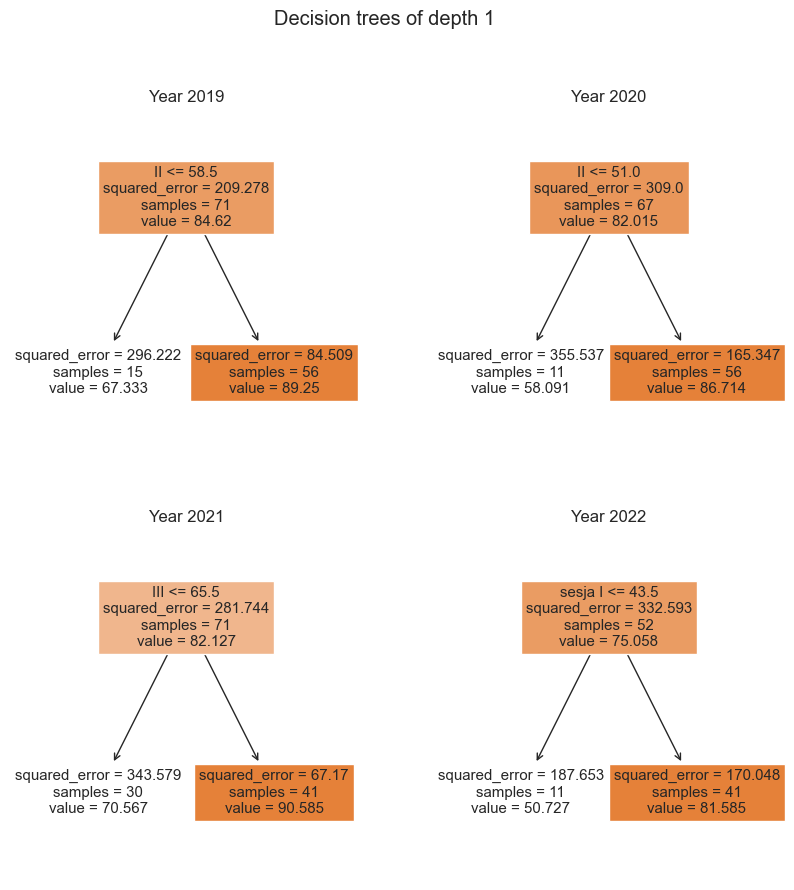

In [4]:
tree = DecisionTreeRegressor(max_depth = max_depth_best, min_samples_leaf = min_samples_leaf_best)
        
err_tr_tree = []
err_dev_tree = []
tree_pred = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plt.title('Dec4')
plt.suptitle('Decision trees of depth 1')
for year in range(19,23):
    X_train = X_slice[year]
    y_train = y_slice[year]
    X_dev = X_yr[year]
    y_dev = y_yr[year]
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_dev_pred = tree.predict(X_dev)

    err_tr_tree.append(mse(y_train_pred, y_train))
    err_dev_tree.append(mse(y_dev_pred, y_dev))
    
    a = int((year - 19)/2) 
    b = ((year - 19) % 2) 
    
    plot_tree(tree, feature_names=X_train.columns, filled=True, ax = axes[a][b]);
    axes[a][b].set_title('Year 20'+str(year))
    
    tree_pred.extend(y_dev_pred)

plt.show()    

It seems sensible that first, fifth and sixth entry are the ones that are the most important. If we look back at the coefficient that we obtained from linear regressions, we see that it was the case all along.

Since the max_depth obtained (i.e. 1) allows us to effectively make 2 different outputs, let's try making a random forest of max_depth = 1 hoping that hopefully it will make it work better. In order to focus only on significant columns, we'll restrict our inputs to first, fifth and sixth column.

482.0905479926199 10


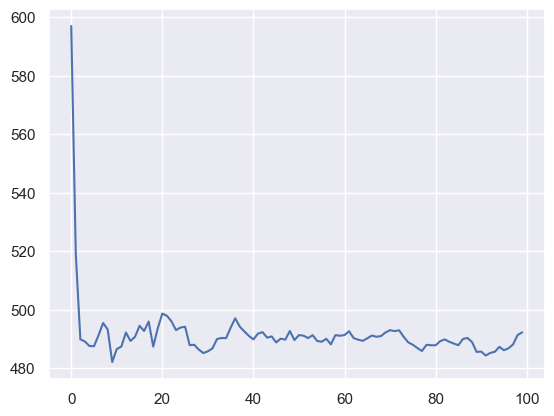

In [5]:
X_slice_trimmed, X_dev_trimmed = {}, {}
err_tr_forest, err_dev_forest = {}, {}
err_dev_mean = []


for n_estimators in range(1,101):
    forest = RandomForestRegressor(n_estimators = n_estimators, max_depth = 1, random_state = 42)
    for year in range(19,23):
        X_train, y_train = X_slice[year].iloc[:,[0,4,5]], y_slice[year] #selecting only significant cols
        X_dev, y_dev = X_yr[year].iloc[:,[0,4,5]], y_yr[year]   

        forest.fit(X_train, y_train)    
        y_train_pred = forest.predict(X_train)
        y_dev_pred = forest.predict(X_dev)

        err_tr_forest[year] = mse(y_train_pred, y_train)
        err_dev_forest[year] = mse(y_dev_pred, y_dev)
   
    err_dev_mean.append(np.max(list(err_dev_forest.values())))

n_estimators_best = err_dev_mean.index(min(err_dev_mean)) + 1
print(min(err_dev_mean), n_estimators_best)
plt.plot(err_dev_mean)


It seems that the results are the best for n_estimators = 10. Now let's check what error can we expect using these parameters by running it once more but with different random_state.

In [6]:
err_tr_forest, err_dev_forest = [], []
forest_pred = []

forest = RandomForestRegressor(n_estimators = n_estimators_best, max_depth = 1, random_state = 24)
for year in range(19,23):
    X_train, y_train = X_slice[year].iloc[:,[0,4,5]], y_slice[year] #selecting only significant cols
    X_dev, y_dev = X_yr[year].iloc[:,[0,4,5]], y_yr[year]   

    forest.fit(X_train, y_train)    
    y_train_pred = forest.predict(X_train)
    y_dev_pred = forest.predict(X_dev)

    err_tr_forest.append(mse(y_train_pred, y_train))
    err_dev_forest.append(mse(y_dev_pred, y_dev))
    
    forest_pred.extend(y_dev_pred)
    
    print('Train error: ' + str(err_tr_forest[-1]))
    print('Dev error: ' + str(err_dev_forest[-1]) + '\n')

print('Average forest train error: ' + str(np.max(err_tr_forest)))
print('Average forest dev error: ' + str(np.max(err_dev_forest)))


Train error: 108.08367528593556
Dev error: 445.9147062510083

Train error: 161.81685961781625
Dev error: 160.46792780978873

Train error: 153.594297875961
Dev error: 207.73989338761558

Train error: 136.8997539338588
Dev error: 266.14901260941133

Average forest train error: 161.81685961781625
Average forest dev error: 445.9147062510083


368.0780834307428 9


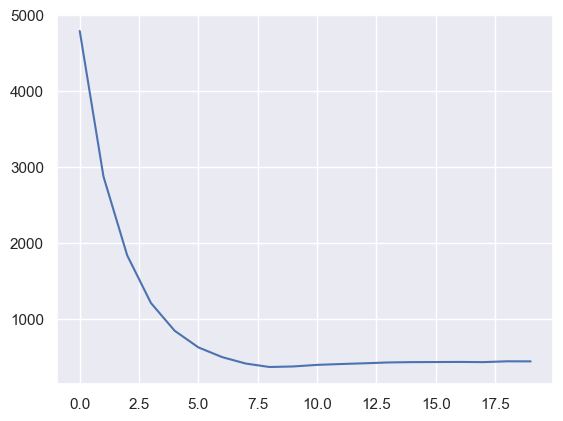

In [7]:
X_slice_trimmed, X_dev_trimmed = {}, {}
err_tr_xgb, err_dev_xgb = {}, {}
err_dev_xgb_mean = []


for n_estimators in range(1,21):
    xgb = XGBRegressor(n_estimators = n_estimators, max_depth = 1, random_state = 42)
    for year in range(19,23):
        X_train, y_train = X_slice[year].iloc[:,[0,4,5]], y_slice[year] #selecting only significant cols
        X_dev, y_dev = X_yr[year].iloc[:,[0,4,5]], y_yr[year]   

        xgb.fit(X_train, y_train)    
        y_train_pred = xgb.predict(X_train)
        y_dev_pred = xgb.predict(X_dev)

        err_tr_xgb[year] = mse(y_train_pred, y_train)
        err_dev_xgb[year] = mse(y_dev_pred, y_dev)
    
    err_dev_xgb_mean.append(np.max(list(err_dev_xgb.values())))
n_estimators_xgb_best = err_dev_xgb_mean.index(min(err_dev_xgb_mean)) + 1
print(np.min(err_dev_xgb_mean), n_estimators_xgb_best)
plt.plot(err_dev_xgb_mean)
    

It seems that the best results are achieved for n_estimators = 9. Let's check on different random_state, how it works.

In [8]:
err_tr_xgb, err_dev_xgb = [], []
xgb_pred = []

xgb = XGBRegressor(n_estimators = n_estimators_xgb_best, max_depth = 1, random_state = 24)
for year in range(19,23):
    X_train, y_train = X_slice[year].iloc[:,[0,4,5]], y_slice[year] #selecting only significant cols
    X_dev, y_dev = X_yr[year].iloc[:,[0,4,5]], y_yr[year]   

    xgb.fit(X_train, y_train)    
    y_train_pred = xgb.predict(X_train)
    y_dev_pred = xgb.predict(X_dev)

    err_tr_xgb.append(mse(y_train_pred, y_train))
    err_dev_xgb.append(mse(y_dev_pred, y_dev))
    
    xgb_pred.extend(y_dev_pred)
    
    print('Train error: ' + str(err_tr_xgb[-1]))
    print('Dev error: ' + str(err_dev_xgb[-1]) + '\n')

print('Average XGBoost train error: ' + str(np.max(err_tr_xgb)))
print('Average XGBoost dev error: ' + str(np.max(err_dev_xgb)))


Train error: 94.21405810602444
Dev error: 354.4834175174765

Train error: 139.01657459065282
Dev error: 135.57402033344115

Train error: 134.06505390140126
Dev error: 158.30926835115042

Train error: 113.98728942388614
Dev error: 368.0780834307428

Average XGBoost train error: 139.01657459065282
Average XGBoost dev error: 368.0780834307428


Hurray! Finally we managed to beat Restricted Linear Regression.

Let's sum up the information that we obtained so far. The following dataframe lists cross-val errors that we obtained with different models on different years.

In [9]:
data ={}
col_names = ['Name', 19, 20, 21, 22, 'total']

data = [['Decision tree'] + [int(x) for x in err_dev_tree] + [int(np.max(err_dev_tree))],
       ['Random forest'] + [int(x) for x in err_dev_forest] + [int(np.max(err_dev_forest))],
        ['XGBoost'] + [int(x) for x in err_dev_xgb] + [(int(np.max(err_dev_xgb)))]]

models = pd.DataFrame(data, columns = col_names)

models

,Name,19,20,21,22,total
0,Decision tree,507,241,282,387,507
1,Random forest,445,160,207,266,445
2,XGBoost,354,135,158,368,368


In [10]:
models.to_excel('basic_models.xlsx')

At the end, let's add our predictions to the cross-val predictions to df in order to see on several examples how the predictions are doing.

In [11]:
df_pred = pd.read_excel('df_pred.xlsx')
df_pred = df_pred.drop(columns = ['Unnamed: 0'])
df_pred['tree_pred'] = tree_pred
df_pred['forest_pred'] = forest_pred
df_pred['xgb_pred'] = xgb_pred
df_pred.to_excel('df_pred_full.xlsx')